In [2]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image


  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [5]:
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip


rm: cannot remove 'flower_data': No such file or directory


In [19]:
!pip install pillow==4.1.1

    100% |████████████████████████████████| 5.7MB 7.0MB/s 
  Found existing installation: Pillow 5.4.0
    Uninstalling Pillow-5.4.0:
      Successfully uninstalled Pillow-5.4.0


In [0]:
from torchvision import datasets, transforms, models

In [0]:
data = 'flower_data'
train_dir =  data+'/train'
valid_dir = data+'/valid'

In [0]:
data_transform = {
    'training' : transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]),
                                                            
    'validation' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]) 
}

In [0]:
imagedata = {
        'training' : datasets.ImageFolder(train_dir, transform=data_transform['training']),
        'validation' : datasets.ImageFolder(valid_dir, transform=data_transform['validation'])

}

In [0]:
data_loader = {
    'training' : torch.utils.data.DataLoader(imagedata['training'], batch_size=64, shuffle=True),
    'validation' : torch.utils.data.DataLoader(imagedata['validation'], batch_size=64, shuffle=True)
}
class_to_idx = imagedata['training'].class_to_idx

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
from PIL import Image
import matplotlib.gridspec as gridspec
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from collections import OrderedDict
import json
import cv2

224


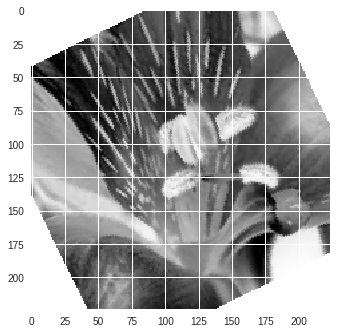

In [20]:
images, labels = next(iter(data_loader["training"]))
print(len(images[0,2]))
plt.imshow(images[0,0])

In [0]:
def get_model():
  model = models.densenet121(pretrained=True)
  return model

def build_model(hidden_layers, class_to_idx):
    model = get_model()
    for param in model.parameters():
        param.requires_grad = False
    
    classifier_input_size = model.classifier.in_features
    print("Input size: ", classifier_input_size)
    output_size = 102

    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(classifier_input_size, hidden_layers)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(hidden_layers, output_size)),
        ('output', nn.LogSoftmax(dim=1))
    ]))
    
    model.classifier = classifier
    model.class_to_idx = class_to_idx
    return model

In [22]:
hidden_layers = 512
model = build_model(hidden_layers, class_to_idx)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 78437554.26it/s]


Input size:  1024


In [0]:
def train(model, epochs, learning_rate, criterion, optimizer, training_loader, validation_loader):
    
    model.train()
    print_every = 40
    steps = 0
    use_gpu = False
    
    if torch.cuda.is_available():
        use_gpu = True
        model.cuda()
    else:
        model.cpu()

    for epoch in range(epochs):
        running_loss = 0
        for inputs, labels in iter(training_loader):
            steps += 1

            if use_gpu:
                inputs = Variable(inputs.float().cuda())
                labels = Variable(labels.long().cuda()) 
            else:
                inputs = Variable(inputs)
                labels = Variable(labels) 

            optimizer.zero_grad()
            output = model.forward(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if steps % print_every == 0:
                validation_loss, accuracy = validate(model, criterion, validation_loader)

                print("Epoch: {}/{} ".format(epoch+1, epochs),
                        "Training Loss: {:.3f} ".format(running_loss/print_every),
                        "Validation Loss: {:.3f} ".format(validation_loss),
                        "Validation Accuracy: {:.3f}".format(accuracy))

In [0]:
def validate(model, criterion, data_loader):
    model.eval()
    accuracy = 0
    test_loss = 0
    
    for inputs, labels in iter(data_loader):
        if torch.cuda.is_available():
            inputs = Variable(inputs.float().cuda(), volatile=True)
            labels = Variable(labels.long().cuda(), volatile=True) 
        else:
            inputs = Variable(inputs, volatile=True)
            labels = Variable(labels, volatile=True)

        output = model.forward(inputs)
        test_loss += criterion(output, labels).data[0]
        ps = torch.exp(output).data 
        equality = (labels.data == ps.max(1)[1])
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss/len(data_loader), accuracy/len(data_loader)

In [41]:
epochs = 9
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
train(model, epochs, learning_rate, criterion, optimizer, data_loader['training'], data_loader['validation'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


Epoch: 1/9  Training Loss: 0.442  Validation Loss: 0.371  Validation Accuracy: 0.909
Epoch: 1/9  Training Loss: 0.861  Validation Loss: 0.307  Validation Accuracy: 0.922
Epoch: 2/9  Training Loss: 0.169  Validation Loss: 0.326  Validation Accuracy: 0.914
Epoch: 2/9  Training Loss: 0.539  Validation Loss: 0.326  Validation Accuracy: 0.911
Epoch: 2/9  Training Loss: 0.915  Validation Loss: 0.312  Validation Accuracy: 0.915
Epoch: 3/9  Training Loss: 0.323  Validation Loss: 0.325  Validation Accuracy: 0.919
Epoch: 3/9  Training Loss: 0.696  Validation Loss: 0.359  Validation Accuracy: 0.914
Epoch: 4/9  Training Loss: 0.090  Validation Loss: 0.356  Validation Accuracy: 0.916
Epoch: 4/9  Training Loss: 0.463  Validation Loss: 0.308  Validation Accuracy: 0.920
Epoch: 4/9  Training Loss: 0.831  Validation Loss: 0.323  Validation Accuracy: 0.916
Epoch: 5/9  Training Loss: 0.269  Validation Loss: 0.317  Validation Accuracy: 0.922
Epoch: 5/9  Training Loss: 0.635  Validation Loss: 0.303  Validat

In [42]:
test_loss, accuracy = validate(model, criterion, data_loader['validation'])
print("Val. Accuracy: {:.3f}".format(accuracy))
print("Val. Loss: {:.3f}".format(test_loss))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


Val. Accuracy: 0.906
Val. Loss: 0.346


In [0]:
checkpoint_path = 'checkpoint.pt'

state = {
    'arch': 'densenet121',
    'learning_rate': learning_rate,
    'hidden_layers': hidden_layers,
    'epochs': epochs,
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'class_to_idx' : model.class_to_idx
}

torch.save(state, checkpoint_path)

In [44]:
checkpoint_path = 'checkpoint.pt'
state = torch.load(checkpoint_path)
learning_rate = state['learning_rate']
class_to_idx = state['class_to_idx']


model = build_model(hidden_layers, class_to_idx)

model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

print("Loaded '{}' (arch={}, hidden_layers={}, epochs={})".format(
    checkpoint_path, 
    state['arch'], 
    state['hidden_layers'], 
    state['epochs']))

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Input size:  1024
Loaded 'checkpoint.pt' (arch=densenet121, hidden_layers=512, epochs=9)


In [47]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [0]:
from torch import nn

model = models.vgg16()


model.classifier[6]= nn.Linear(4096,102)

torch.cuda.is_available()



True

In [0]:
models.densenet121().classifier


/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Linear(in_features=1024, out_features=1000, bias=True)

In [46]:
from google.colab import files
files.download('checkpoint.pt')

MessageError: ignored